# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training.

## Import Resources

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [31]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [32]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.16.1
	• Running on GPU


2024-03-20 11:17:41.167934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 11:17:41.168212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 11:17:41.168387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Loading the Dataset

We are about to load the Fashion-MNIST dataset using `tensorflow_datasets`, as we have previously done. However, this time, we will modify the default dataset partitioning. We will allocate 80% of the `train` set for training purposes and 20% for validation. The `test` set will remain unchanged.

The Slicing API from TFDS offers an efficient method to slice data utilizing Python's slice notation and percentage.

```python
splits = ['train[:80%]', 'train[80%:]', 'test']
dataset = tfds.load('fashion_mnist', split=splits)
```

TFDS ensures that, for any given dataset, examples are shuffled deterministically on disk during the dataset generation process. Consequently, generating the dataset twice (on two different computers) will not alter the order of examples.

Furthermore, the subsplit API consistently selects the same examples regardless of the platform or architecture used. This means that `set('train[:20%]')` is equivalent to `set('train[:10%]')` combined with `set('train[10%:20%]')`.

Nonetheless, the sequence in which examples are accessed may not be deterministic, depending on various factors (e.g., the `shuffle_files` parameter).

For more information on `subsplit` and additional methods to segment your data, please refer to the [Documentation on Splits and Slicing](https://www.tensorflow.org/datasets/splits).

In [33]:
splits = ['train[:80%]', 'train[80%:]', 'test']

# Load the 'fashion_mnist' dataset
dataset, dataset_info = tfds.load('fashion_mnist', as_supervised=True, with_info=True, split=splits)

# Split the dataset into training and test sets
training_set, validation_set, test_set = dataset

When we use `split=['train[:80%]', 'train[80%:]', 'test']`, `tensorflow_datasets` returns a tuple with our sub-splits. Since we divided our dataset into 3 sets, then, in this case, `dataset` should be a tuple with 3 elements.

In [34]:
# Check that dataset is a tuple
print('dataset has type:', type(dataset))

# Print the number of elements in dataset
print(f'dataset has {len(dataset):,} elements ')

dataset has type: <class 'list'>
dataset has 3 elements 


In [35]:
# Display dataset
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [36]:
# Display dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

## Explore the Dataset

In [37]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = len(training_set)
num_validation_examples = len(validation_set)
num_test_examples = len(test_set)

print(f'There are {num_training_examples:,} images in the training set')
print(f'There are {num_validation_examples:,} images in the validation set')
print(f'There are {num_test_examples:,} images in the test set')

There are 42,000 images in the training set
There are 14,000 images in the validation set
There are 14,000 images in the test set


In [38]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Create Pipeline

In [39]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build the Model

Here we'll build and compile our model as usual.

In [40]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Evaluate Loss and Accuracy on the Test Set

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. Let's see how the model performs on our test set.

In [42]:
loss, accuracy = model.evaluate(testing_batches)

print(f'\nLoss on the TEST Set: {loss:,.3f}')
print(f'Accuracy on the TEST Set: {accuracy:.3%}')

157/157 [==============================] - 1s 2ms/step - loss: 2.3940 - accuracy: 0.0806

Loss on the TEST Set: 2.394
Accuracy on the TEST Set: 8.060%


The network is untrained so it's making random guesses and we should see an accuracy around 10%.

## Train the Model with the Validation Set

Now let's train our network as usual, but this time we are also going to incorporate our validation set into the training process. 

During training, the model will only use the training set in order to decide how to modify its weights and biases. Then, after every training epoch we calculate the loss on the training and validation sets. These metrics tell us how well our model is "learning" because it they show how well the model generalizes to data that is not used for training. It's important to remember that the model does not use any part of the validation set to tune its weights and biases, therefore it can tell us if we're overfitting the training set.

We can incorporate our validation set into the training process by including the `validation_data=validation_batches` argument in the `.fit` method.

In [43]:
EPOCHS = 30

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30


750/750 [==============================] - 4s 3ms/step - loss: 0.5196 - accuracy: 0.8148 - val_loss: 0.4209 - val_accuracy: 0.8493
Epoch 2/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3787 - accuracy: 0.8618 - val_loss: 0.3424 - val_accuracy: 0.8742
Epoch 3/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3428 - accuracy: 0.8741 - val_loss: 0.3454 - val_accuracy: 0.8717
Epoch 4/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3198 - accuracy: 0.8807 - val_loss: 0.3167 - val_accuracy: 0.8844
Epoch 5/30
750/750 [==============================] - 2s 3ms/step - loss: 0.2950 - accuracy: 0.8908 - val_loss: 0.3095 - val_accuracy: 0.8848
Epoch 6/30
750/750 [==============================] - 2s 3ms/step - loss: 0.2849 - accuracy: 0.8931 - val_loss: 0.3078 - val_accuracy: 0.8898
Epoch 7/30
750/750 [==============================] - 2s 3ms/step - loss: 0.2709 - accuracy: 0.8981 - val_loss: 0.2907 - val_accuracy: 0.8940
Epoch 8/30
750/75

## Loss and Validation Plots

If we look at the training and validation losses achieved on epoch 30 above, we see that the loss on the training set is much lower than that achieved on the validation set. This is a clear sign of overfitting. In other words, our model has "memorized" the training set so it performs really well on it, but when tested on data that it wasn't trained on (*i.e.* the validation dataset) it performs poorly. 

Let's take a look at the model's loss and accuracy values obtained during training on both the training set and the validation set. This will allow us to see how well or how bad our model is "learning". We can do this easily by using the `history` object returned by the `.fit` method. The  `history.history` attribute is a **dictionary** with a record of training accuracy and loss values at successive epochs, as well as validation accuracy and loss values when applicable. 

In [44]:
# Check that history.history is a dictionary
print('history.history has type:', type(history.history))

# Print the keys of the history.history dictionary
print('\nThe keys of history.history are:', list(history.history.keys()))

history.history has type: <class 'dict'>

The keys of history.history are: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


Let's use the `history.history` dictionary to plot our model's loss and accuracy values obtained during training.

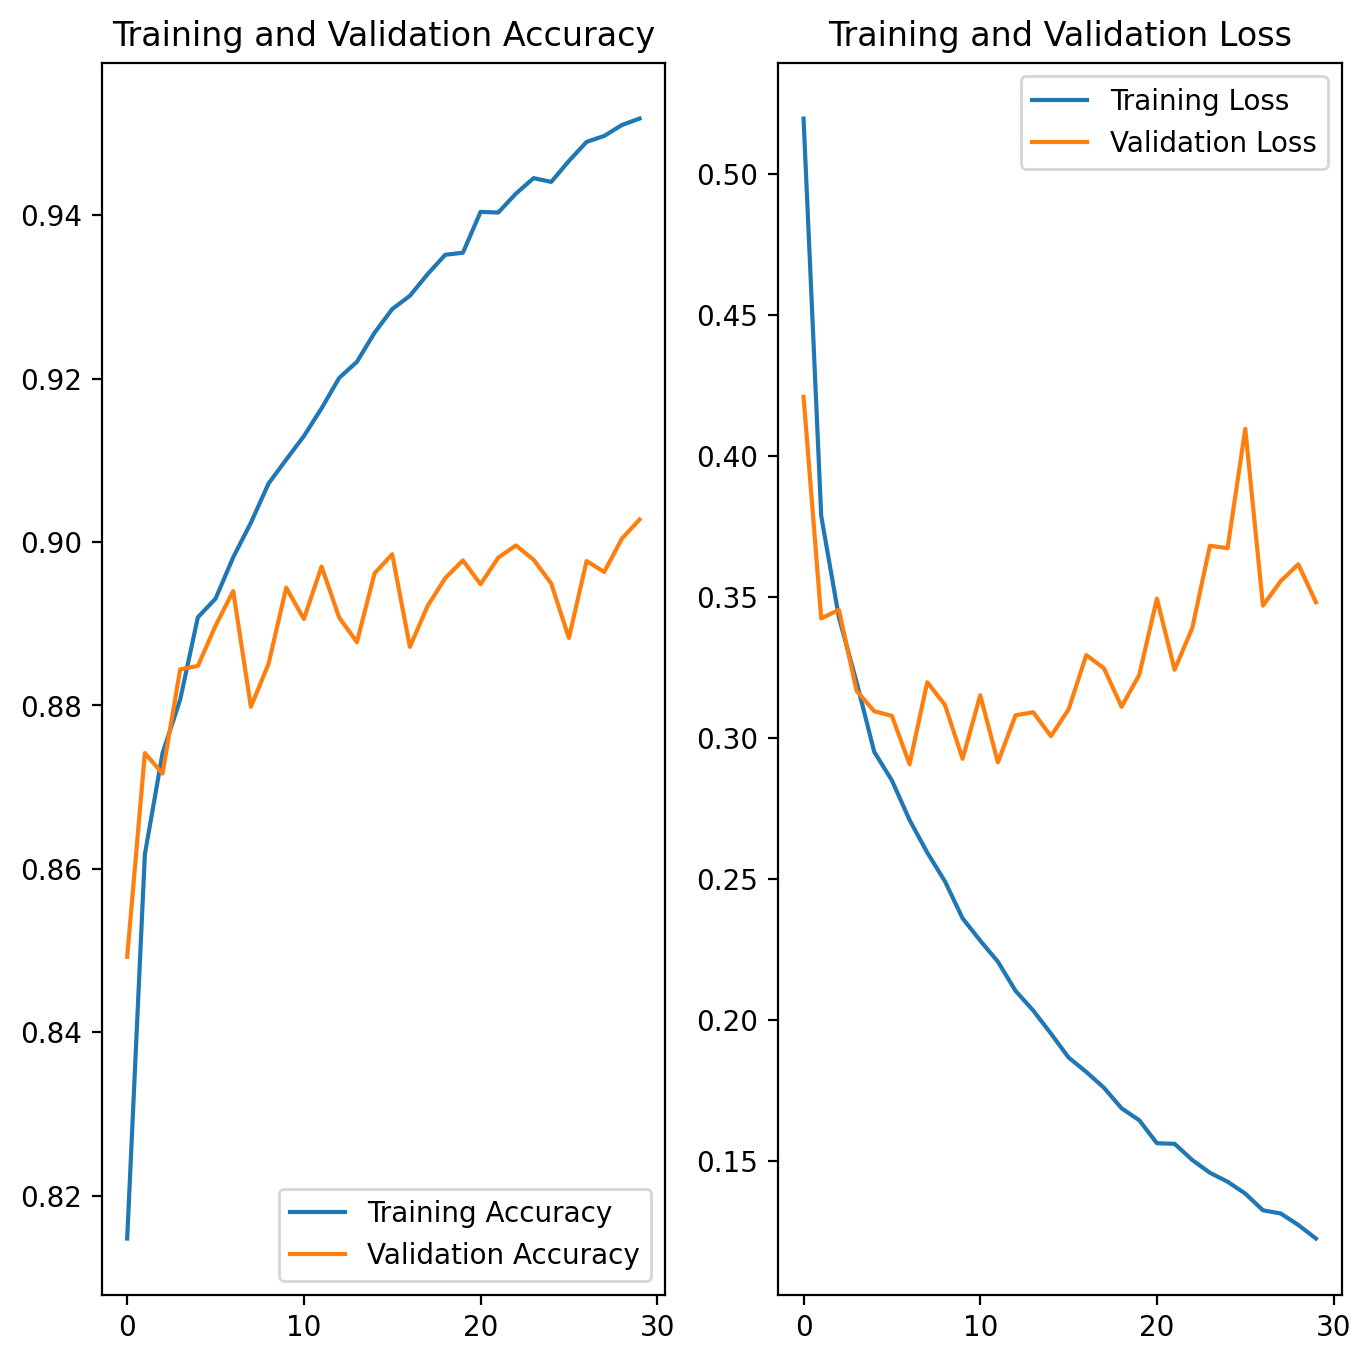

In [45]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Early Stopping

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 
This happens when our model performs really well on the training data but it fails to generalize well enough to also perform well on the validation set. We can tell that this is happening because when we finished training the validation loss is higher than the training loss.

One way to prevent our model from overfitting is by stopping training when we achieve the lowest validation loss. If we take a look at the plots we can see that at the beginning of training the validation loss starts decreasing, then after some epochs it levels off, and then it just starts increasing. Therefore, we can stop training our model when the validation loss levels off, such that our network is accurate but it's not overfitting.

This strategy is called **early-stopping**. We can implement early stopping in `tf.keras` by using a **callback**. A callback is a set of functions to be applied at given stages of the training process. You can pass a list of callbacks to the `.fit()` method by using the `callbacks` keyword argument. 

To implement early-stopping during training we will use the callback:


```python
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
```

The `monitor` argument specifies the quantity we want to monitor during training to determine when to stop training. The `patience` argument determines the number of consecutive epochs with no significant improvement after which training will be stopped. We can also specify the minimum change in the monitored quantity to qualify as an improvement, by specifying the `min_delta` argument. For more information on the early-stopping callback check out the [EarlyStopping 
documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping#class_earlystopping).

In [46]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs=100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/100


750/750 [==============================] - 3s 3ms/step - loss: 0.5237 - accuracy: 0.8127 - val_loss: 0.3864 - val_accuracy: 0.8585
Epoch 2/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3759 - accuracy: 0.8622 - val_loss: 0.3490 - val_accuracy: 0.8731
Epoch 3/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3415 - accuracy: 0.8742 - val_loss: 0.3461 - val_accuracy: 0.8733
Epoch 4/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3198 - accuracy: 0.8811 - val_loss: 0.3074 - val_accuracy: 0.8837
Epoch 5/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2940 - accuracy: 0.8906 - val_loss: 0.3118 - val_accuracy: 0.8860
Epoch 6/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2817 - accuracy: 0.8940 - val_loss: 0.2908 - val_accuracy: 0.8929
Epoch 7/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2691 - accuracy: 0.8994 - val_loss: 0.3079 - val_accuracy: 0.8900
Epoch 8/100

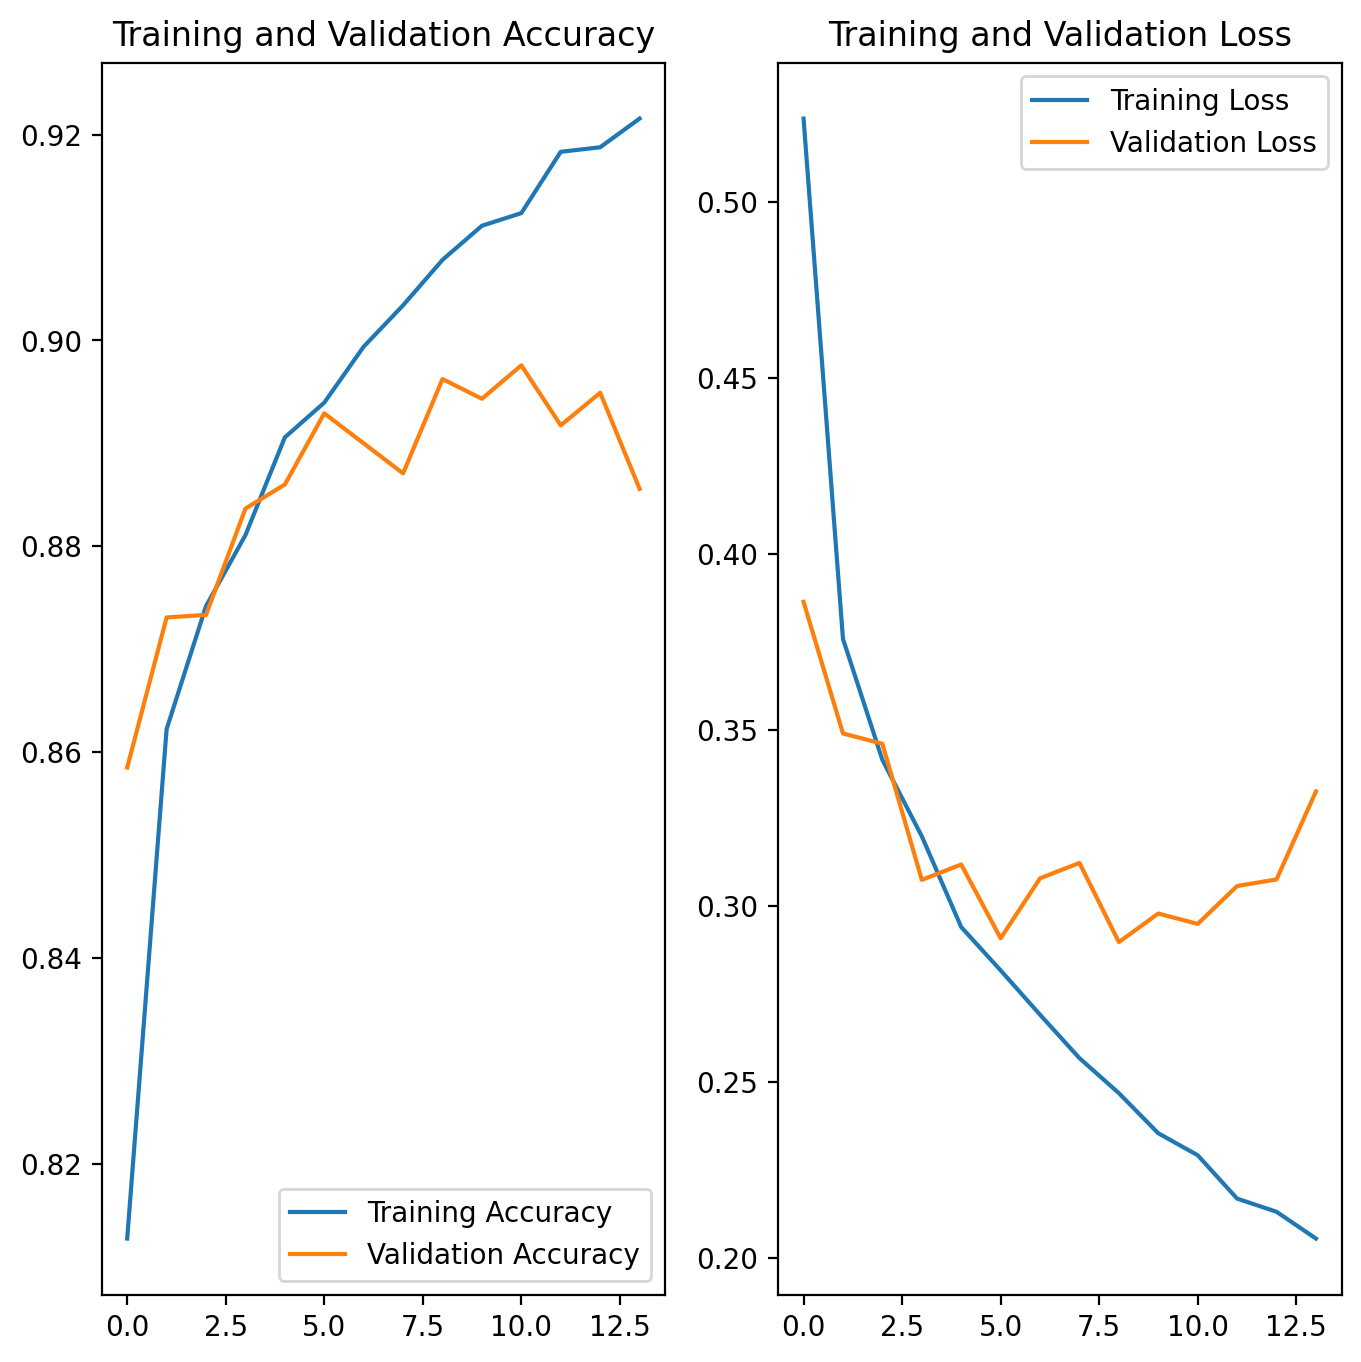

In [47]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Dropout

Another common method to reduce overfitting is called **dropout**, where we randomly drop neurons in our model during training. This forces the network to share information between weights, increasing its ability to generalize to new data. We can implement dropout in `tf.keras` by adding `tf.keras.layers.Dropout()` layers to our models. 

```python
tf.keras.layers.Dropout(rate)
```
randomly sets a fraction `rate` of the dropout layer's input units to 0 at each update during training. The `rate` argument is a float between 0 and 1, that determines the fraction of neurons from the previous layer that should be turned off. For example,  `rate =0.5` will drop 50\% of the neurons. 

It's important to note that we should never apply dropout to the input layer of our network. Also, remember that during training we want to use dropout to prevent overfitting, but during inference we want to use all the neurons in the network. `tf.keras` is designed to care of this automatically, so it uses the dropout layers during training, but automatically ignores them during inference.

> **Exercise:** Add 3 dropout layers with a `rate=0.2` to our previous `model` and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [48]:
## Solution
my_model = tf.keras.Sequential([
           tf.keras.layers.Flatten(input_shape=(28,28,1)),
           tf.keras.layers.Dense(256, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(128, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(64, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(10, activation = 'softmax')
])

my_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

EPOCHS = 30

history = my_model.fit(training_batches,
                       epochs=EPOCHS,
                       validation_data=validation_batches)

Epoch 1/30


750/750 [==============================] - 4s 3ms/step - loss: 0.6376 - accuracy: 0.7713 - val_loss: 0.4171 - val_accuracy: 0.8544
Epoch 2/30
750/750 [==============================] - 2s 3ms/step - loss: 0.4475 - accuracy: 0.8409 - val_loss: 0.3682 - val_accuracy: 0.8609
Epoch 3/30
750/750 [==============================] - 2s 3ms/step - loss: 0.4092 - accuracy: 0.8530 - val_loss: 0.3575 - val_accuracy: 0.8676
Epoch 4/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3771 - accuracy: 0.8630 - val_loss: 0.3370 - val_accuracy: 0.8747
Epoch 5/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3604 - accuracy: 0.8690 - val_loss: 0.3448 - val_accuracy: 0.8703
Epoch 6/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3500 - accuracy: 0.8742 - val_loss: 0.3265 - val_accuracy: 0.8796
Epoch 7/30
750/750 [==============================] - 2s 3ms/step - loss: 0.3363 - accuracy: 0.8787 - val_loss: 0.3102 - val_accuracy: 0.8842
Epoch 8/30
750/75

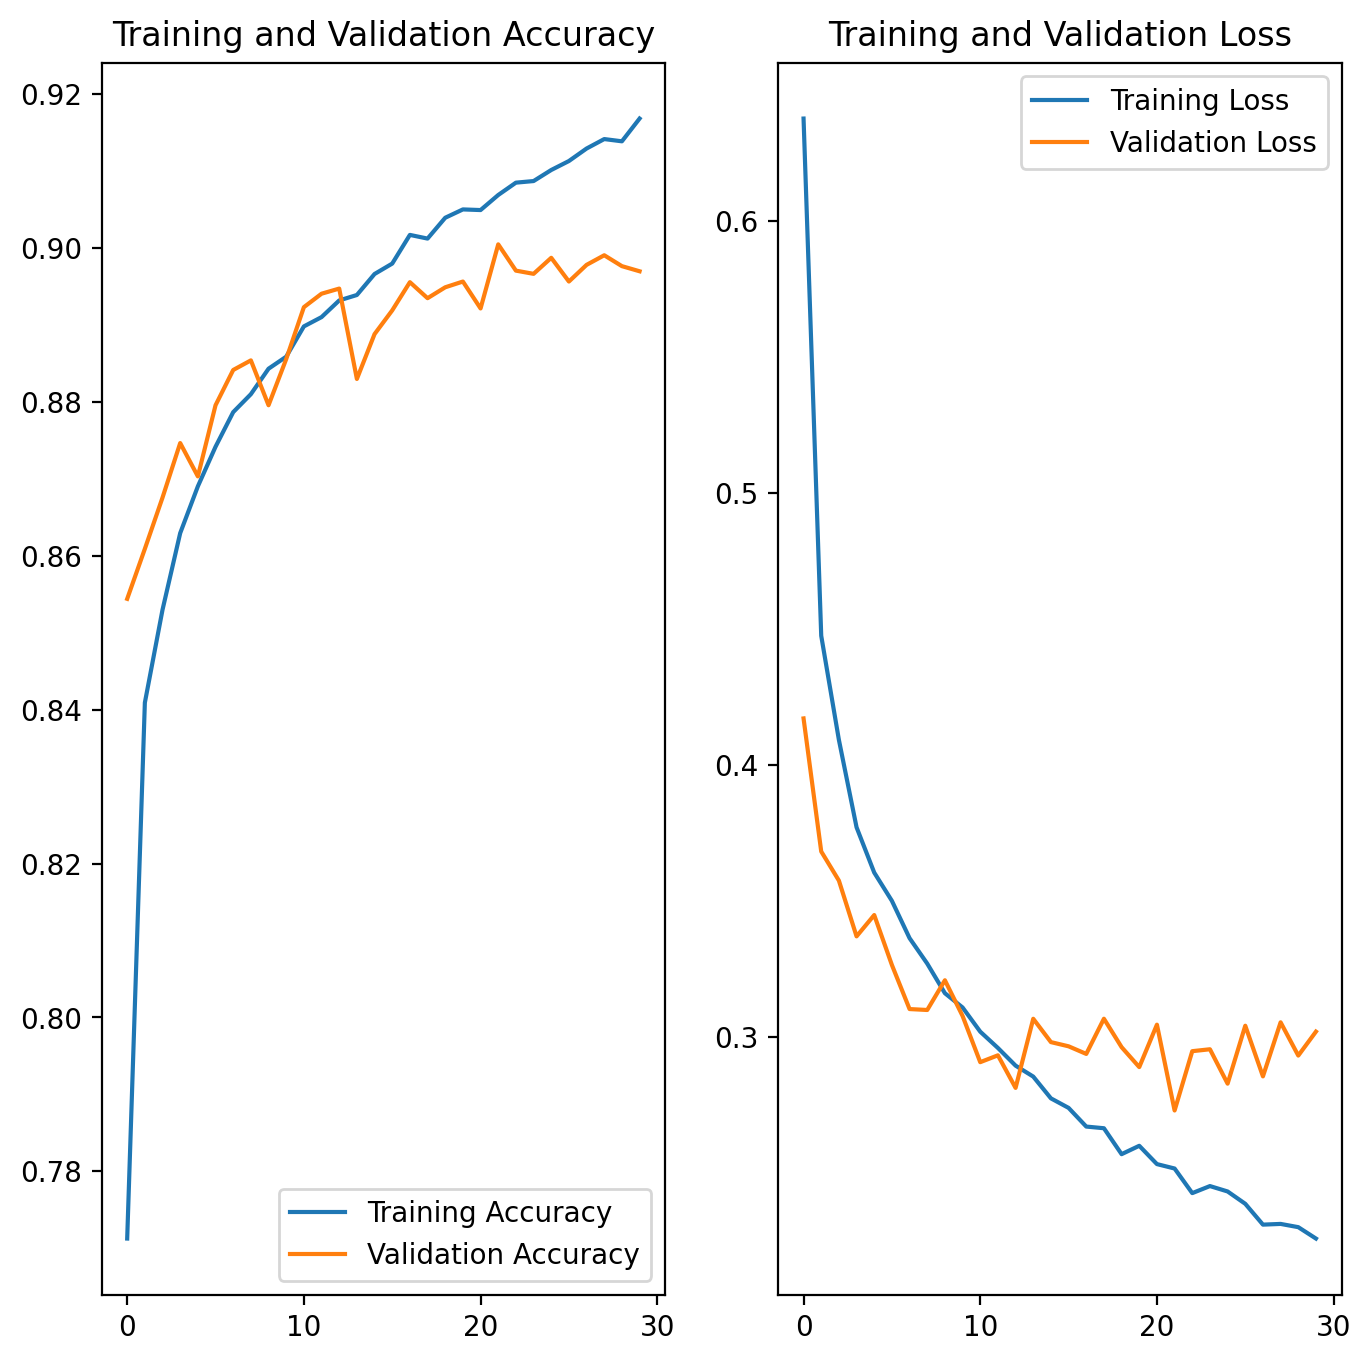

In [49]:
## Solution Continued 
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

Now that the model is trained, we can use it to perform inference. Here we are going to perform inference on 30 images and print the labels in green if our model's prediction matches the true label. On the other hand, if our model's prediction doesn't match the true label, we print the label in red. 

2/2 [==============================] - 0s 3ms/step


2024-03-20 11:20:20.300210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


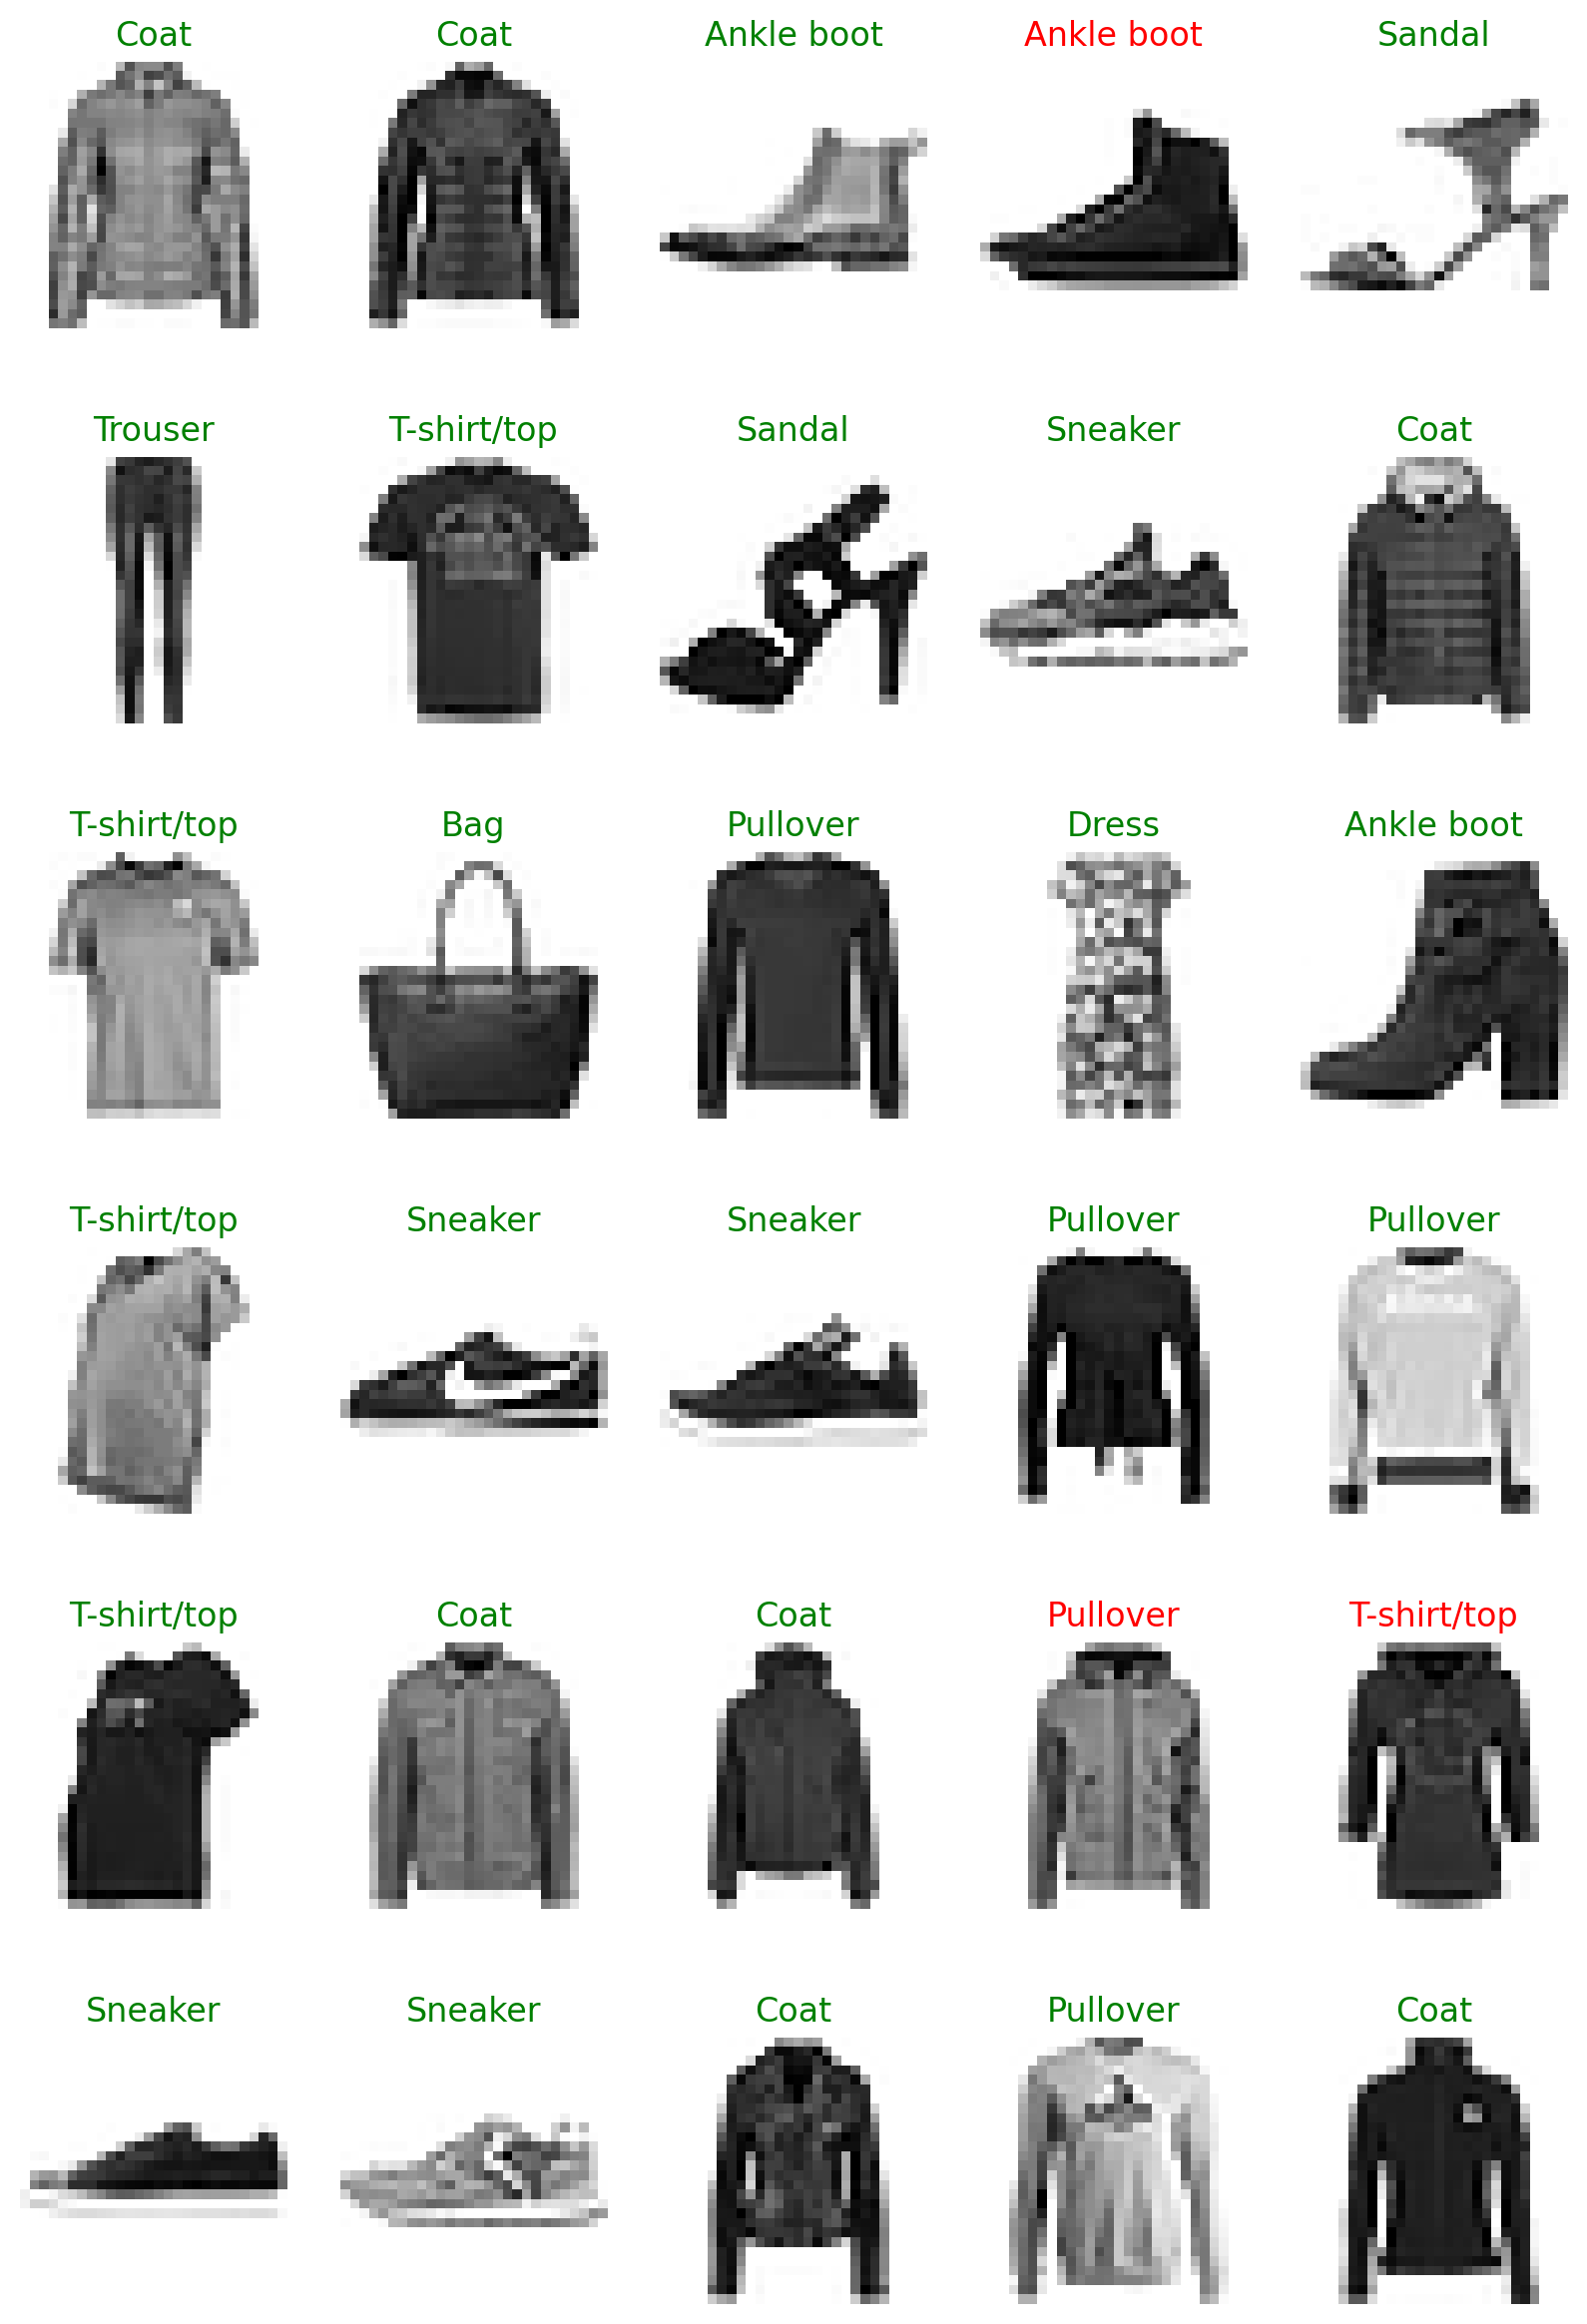

In [50]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()


plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

## Next Up!

In the next lesson, we'll see how to save our trained models. In general, you won't want to train a model every time you need it. Instead, you'll train once, save it, then load the model when you want to train more or use it for inference.